 **Comparison of QNN and CNN models for a standard ML Problem**

In [ ]:
#installing required libraries
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum

     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 5.9MB 5.0MB/s 
     |████████████████████████████████| 5.6MB 23.1MB/s 
     |████████████████████████████████| 1.6MB 51.7MB/s 


Quantum neural network

In [ ]:
# importing required libraries
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq#used for modfiying quanutm circuits
import sympy#for symbolic computation
import numpy as np
import pandas as pd
import collections

# for plotting and visualization of data
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [ ]:
# Importing Data from MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizing the images
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
# Filtering the data for images of digits 1 and 2
def filter(x, y):
    keep = (y == 1) | (y == 2)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

x_train, y_train = filter(x_train, y_train)
x_test, y_test = filter(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12700
Number of filtered test examples: 2167


True


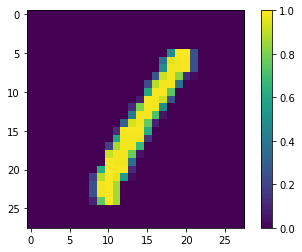

In [ ]:
print(y_train[0])#True for training images which is 1
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

False


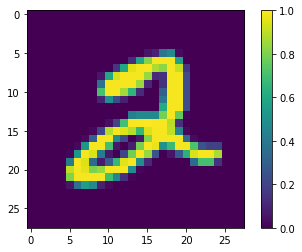

In [ ]:
print(y_train[1])#False for training images which is 2
plt.imshow(x_train[1, :, :, 0])
plt.colorbar()

True


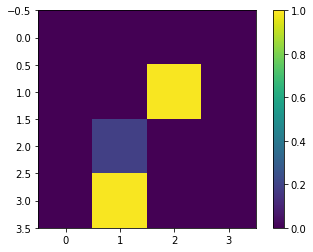

In [ ]:
# Quantum Computation takes too long for original image size so reduction in iamge size
x_train_red = tf.image.resize(x_train, (4,4)).numpy()
x_test_red = tf.image.resize(x_test, (4,4)).numpy()

print(y_train[0])
plt.imshow(x_train_red[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()
#Below image is of 1

False


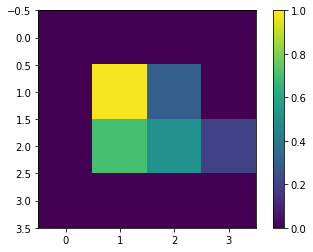

In [ ]:
print(y_train[1])
plt.imshow(x_train_red[1,:,:,0], vmin=0, vmax=1)
plt.colorbar()
#Below image is of 2

In [ ]:
# We need to remove some examples which maybe considered both as 1 and 2
def both_conflict(xs, ys):
    mapping = collections.defaultdict(set)
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(labels.pop())
      else:
          pass

    num_1 = sum(1 for value in mapping.values() if True in value)
    num_2 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 1s: ", num_1)
    print("Number of 2s: ", num_2)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = both_conflict(x_train_red, y_train)

Number of unique images: 7188
Number of 1s:  207
Number of 2s:  207
Number of contradictory images:  207

Initial number of examples:  12700
Remaining non-contradictory examples:  6981


In [ ]:
THRESHOLD = 0.5
#convert to binary for processing using qnn
x_train_binary = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_binary = np.array(x_test_red > THRESHOLD, dtype=np.float32)

In [ ]:
_ = both_conflict(x_train_binary, y_train_nocon)

Number of unique images: 145
Number of 1s:  37
Number of 2s:  37
Number of contradictory images:  37

Initial number of examples:  6981
Remaining non-contradictory examples:  108


In [ ]:
#Here we are rotating the images which exceed the threshold we set by a Pauli-X gate(Equivalent to classical NOT)
def circuit_convert(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circuit = [circuit_convert(x) for x in x_train_binary]
x_test_circuit = [circuit_convert(x) for x in x_test_binary]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


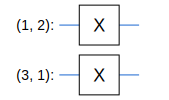

In [ ]:
SVGCircuit(x_train_circuit[0])#visualize the circuit

In [ ]:
#tensorflow quantum requires tensors to process the data
x_train_tfcirc = tfq.convert_to_tensor(x_train_circuit)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circuit)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def Quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Preparing the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

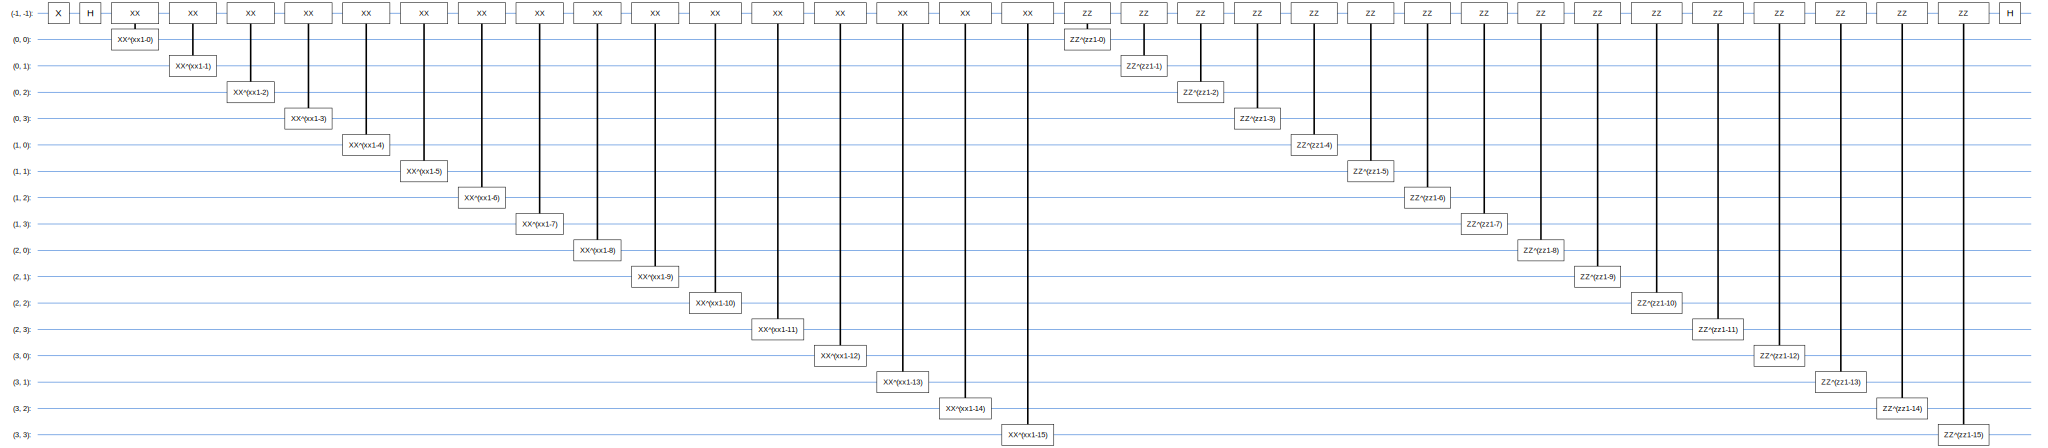

In [ ]:
model_circuit, model_readout = Quantum_model()
SVGCircuit(model_circuit)

In [ ]:
# Here we use Keras to build a Sequential Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
#To use hinge loss function the values must be from [-1,1]
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
#First Method:Using QNN with 3 epochs
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)
#accuracy seems to be lower at 50 percent and time consumed is very high

Epoch 1/3
219/219 [==============================] - 392s 2s/step - loss: 0.8278 - hinge_accuracy: 0.7066 - val_loss: 0.7135 - val_hinge_accuracy: 0.8441
Epoch 2/3
219/219 [==============================] - 391s 2s/step - loss: 0.5434 - hinge_accuracy: 0.8090 - val_loss: 0.7335 - val_hinge_accuracy: 0.5608
Epoch 3/3
68/68 [==============================] - 17s 254ms/step - loss: 0.8233 - hinge_accuracy: 0.5020


In [ ]:
def CNN_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = CNN_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
#This model has more than 1 million parameters and is required to provide very good accuracy

In [ ]:
#Method 2: Using a Classical NN for distinguishing two numbers
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)
#Takes a lot less time and accuracy is also high

68/68 [==============================] - 1s 22ms/step - loss: 0.0134 - accuracy: 0.9945


In [ ]:
def Fair_CNN_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = Fair_CNN_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
#Has 37 parameters,is not that accurate as original model

In [ ]:
#Method 3:Using an fairer CNN with less parameter since this problem is of lesser complexity
model.fit(x_train_binary,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_binary, y_test))

fair_nn_results = model.evaluate(x_test_binary, y_test)
#Accuracy is bad compared to the original model and but competing wiht the QNN model

Epoch 1/20
55/55 - 0s - loss: 0.7461 - accuracy: 0.7071 - val_loss: 0.7163 - val_accuracy: 0.4735
Epoch 2/20
55/55 - 0s - loss: 0.7075 - accuracy: 0.7164 - val_loss: 0.7086 - val_accuracy: 0.4762
Epoch 3/20
55/55 - 0s - loss: 0.6846 - accuracy: 0.7179 - val_loss: 0.7061 - val_accuracy: 0.4762
Epoch 4/20
55/55 - 0s - loss: 0.6684 - accuracy: 0.7179 - val_loss: 0.7061 - val_accuracy: 0.4762
Epoch 5/20
55/55 - 0s - loss: 0.6557 - accuracy: 0.7179 - val_loss: 0.7076 - val_accuracy: 0.4762
Epoch 6/20
55/55 - 0s - loss: 0.6464 - accuracy: 0.7179 - val_loss: 0.7106 - val_accuracy: 0.4762
Epoch 7/20
55/55 - 0s - loss: 0.6391 - accuracy: 0.7179 - val_loss: 0.7142 - val_accuracy: 0.4762
Epoch 8/20
55/55 - 0s - loss: 0.6328 - accuracy: 0.7179 - val_loss: 0.7182 - val_accuracy: 0.4762
Epoch 9/20
55/55 - 0s - loss: 0.6273 - accuracy: 0.7179 - val_loss: 0.7223 - val_accuracy: 0.4762
Epoch 10/20
55/55 - 0s - loss: 0.6223 - accuracy: 0.7179 - val_loss: 0.7267 - val_accuracy: 0.4762
Epoch 11/20
55/55 -

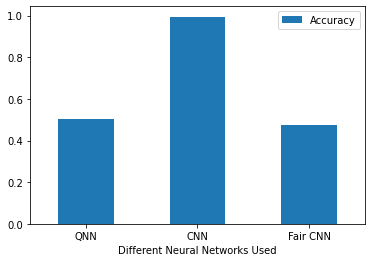

In [ ]:
df = pd.DataFrame({'Different Neural Networks Used':['QNN', 'CNN', 'Fair CNN'], 'Accuracy':[qnn_results[1], cnn_results[1], fair_nn_results[1]]})
ax = df.plot.bar(x='Different Neural Networks Used', y='Accuracy',rot='0')
#The results show that QNN and Fair CNN model has comparable accuracy while CNN shows almost 100% accuracy
#This demonstration shows that QNN shows a quantum advantage only when there are complex layers used and does not perform well for simpler problems